In [1]:
import numpy as np
import pyuvdata
import os
import matplotlib.pyplot as plt


In [2]:
# Get model LSTS
model_filepath = "/safepool/rbyrne/hera_data/H4C-Abscal-Model"
model_filenames = os.listdir(model_filepath)
model_lsts = []
model_lst_filenames = []
for model_file in model_filenames:
    model_uv = pyuvdata.UVData()
    model_uv.read(f"{model_filepath}/{model_file}")
    lsts_new = list(set(model_uv.lst_array))
    model_lsts = np.concatenate((model_lsts, lsts_new))
    filenames_new = np.repeat([model_file], len(lsts_new))
    model_lst_filenames = np.concatenate((model_lst_filenames, filenames_new))

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.5049646242621317e-10, largest imaginary/real ratio was 1.1618951822369998e-15.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.292133371769155e-10, largest imaginary/real ratio was 1.3277846097372624e-15.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.4157853988361357e-10, largest imaginary/real ratio was 1.4752735754290612e-15.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.4640716982809504e-10, largest imaginary/real ratio was 1.4994253786609909e-15.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.27008

In [3]:
data_uv = pyuvdata.UVData()
data_uv.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
use_file = True
for use_lst in list(set(data_uv.lst_array)):
    if use_lst <= np.min(model_lsts):
        use_lst += 2 * np.pi
    elif use_lst >= np.max(model_lsts):
        use_lst -= 2 * np.pi
    lst_distance = np.abs(model_lsts - use_lst)
    if np.sort(lst_distance)[1] > 0.0015 / 2:  # Model for the file LST does not exist
        use_file = False

In [4]:
data = data_uv.select(lsts=use_lst, inplace=False)
data.inflate_by_redundancy(use_grid_alg=True)
red_baselines, _, _, conj_red_baselines = data.get_redundancies(include_conjugates=True)

Missing some redundant groups. Filling in available data.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.


In [5]:
def get_antenna_pair_from_baseline_nums(baseline_nums):
    ant2 = (baseline_nums - 2**16)%2048
    ant1 = [int(value) for value in (baseline_nums - 2**16 - ant2)/2048]
    return list(zip(ant1, ant2))

In [6]:
get_antenna_pair_from_baseline_nums(np.array(red_baselines[-1]))

[(222, 22),
 (239, 34),
 (240, 35),
 (255, 47),
 (256, 48),
 (257, 49),
 (270, 61),
 (271, 62),
 (272, 63),
 (273, 64),
 (284, 76),
 (285, 77),
 (286, 78),
 (287, 79),
 (288, 80),
 (297, 92),
 (298, 93),
 (299, 94),
 (300, 95),
 (301, 96),
 (302, 97),
 (309, 109),
 (310, 110),
 (311, 111),
 (312, 112),
 (313, 113),
 (314, 114),
 (315, 115),
 (343, 248)]

Missing some redundant groups. Filling in available data.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.
invalid value encountered in cast
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.5228813360774725e-10, largest imaginary/real ratio was 1.3585761536503578e-15.
invalid value encountered in cast


1141.3302247510278
501.03265386688753
1485.3420489595385


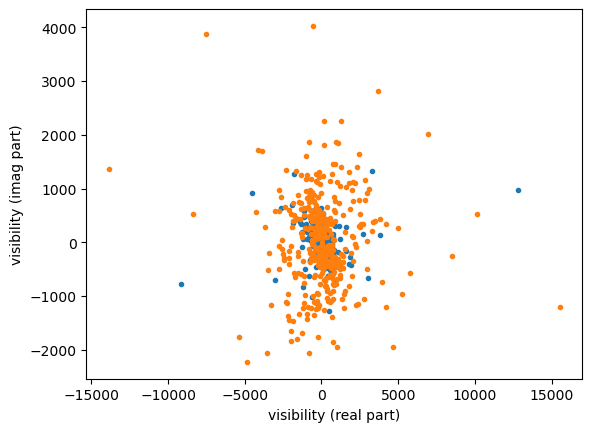

Missing some redundant groups. Filling in available data.
The use_grid_alg parameter is not set. Defaulting to True to use the new gridding based algorithm (developed by the HERA team) rather than the older clustering based algorithm. This is change to the default, to use the clustering algorithm set use_grid_alg=False.
invalid value encountered in cast
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 1.529000470647994e-10, largest imaginary/real ratio was 1.3306492654784096e-15.
invalid value encountered in cast


1130.8189680766761
501.7870985183413
1481.7752314881068


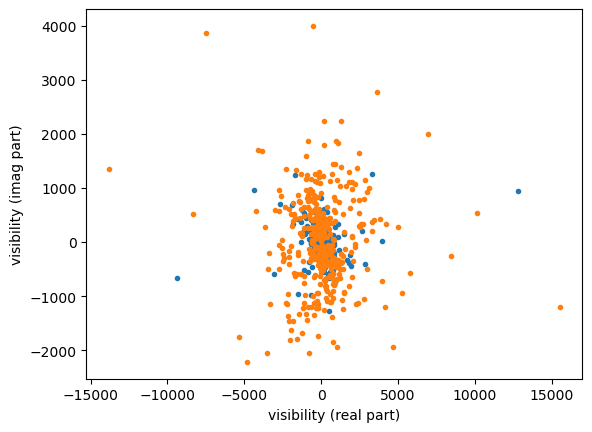

In [7]:
difference=False
if use_file:  # Keep only files where all LSTs are covered by the model
    model_uv_list = []
    for time_ind, use_lst in enumerate(list(set(data_uv.lst_array))):
        lst_distance = np.abs(model_lsts - use_lst)
        ind1 = np.where(lst_distance == np.min(lst_distance))[0]
        # ind2 = np.where(lst_distance == np.sort(lst_distance)[1])[0]
        lst1 = model_lsts[ind1]
        model_filename1 = model_lst_filenames[ind1][0]

        data = data_uv.select(lsts=use_lst, polarizations=[-5], inplace=False)
        data.conjugate_bls()
        data.inflate_by_redundancy(use_grid_alg=True)
        red_baselines, _, _, conj_red_baselines = data.get_redundancies(include_conjugates=True)
        data.compress_by_redundancy()
        data.phase_to_time(np.mean(data.time_array))

        red_groups_data = np.full((data.Nbls), np.nan, int)
        for bl_ind, baseline in enumerate(list(zip(data.ant_1_array, data.ant_2_array))):
            for red_ind, red_group in enumerate(red_baselines):
                red_group_ants = get_antenna_pair_from_baseline_nums(np.array(red_group))
                if baseline in red_group_ants:
                    red_groups_data[bl_ind] = red_ind
                elif baseline[::-1] in red_group_ants:
                    ant1 = data.ant_2_array[bl_ind]
                    ant2 = data.ant_1_array[bl_ind]
                    data.baseline_array[bl_ind] = 2048*ant1 + ant2 + 2**16
                    data.data_array[bl_ind, :, :] = np.conj(
                        data.data_array[bl_ind, :, :]
                    )
                    data.ant_1_array[bl_ind] = ant2
                    data.ant_2_array[bl_ind] = ant1
                    red_groups_data[bl_ind] = red_ind

        model = pyuvdata.UVData()
        model.read(f"{model_filepath}/{model_filename1}")
        model.conjugate_bls()
        model.compress_by_redundancy()
        model.select(lsts=model_lsts[np.where(lst_distance == np.min(lst_distance))[0]], polarizations=[-5], inplace=True)
        model.phase_to_time(np.mean(data.time_array))

        red_groups_model = np.full((model.Nbls), np.nan, int)
        for bl_ind, baseline in enumerate(
            list(zip(model.ant_1_array, model.ant_2_array))
        ):
            for red_ind, red_group in enumerate(red_baselines):
                red_group_ants = get_antenna_pair_from_baseline_nums(
                    np.array(red_group)
                )
                if baseline in red_group_ants:
                    red_groups_model[bl_ind] = red_ind
                    continue
                elif baseline[::-1] in red_group_ants:
                    ant1 = model.ant_2_array[bl_ind]
                    ant2 = model.ant_1_array[bl_ind]
                    model.baseline_array[bl_ind] = 2048 * ant1 + ant2 + 2**16
                    model.data_array[bl_ind, :, :] = np.conj(
                        model.data_array[bl_ind, :, :]
                    )
                    model.ant_1_array[bl_ind] = ant2
                    model.ant_2_array[bl_ind] = ant1
                    red_groups_model[bl_ind] = red_ind
                    continue

        use_red_groups = [group for group in red_groups_data if group in red_groups_model]
        use_data = np.zeros((len(use_red_groups), data.Nfreqs, data.Npols), dtype=complex)
        use_model = np.zeros(
            (len(use_red_groups), data.Nfreqs, data.Npols), dtype=complex
        )
        for group_ind, group in enumerate(use_red_groups):
            use_data[group_ind, :, :] = data.data_array[np.where(red_groups_data == group)[0], :, :]
            use_data[
                np.where(data.flag_array[np.where(red_groups_data == group)[0], :, :])
            ] = np.nan + 1j*np.nan
            use_model[group_ind, :, :] = model.data_array[
                np.where(red_groups_model == group)[0], :, :
            ]
            use_model[
                np.where(data.flag_array[np.where(red_groups_data == group)[0], :, :])
            ] = (np.nan + 1j * np.nan)

        print(np.nanmean(np.abs(use_data[:, 0, :] - use_model[:, 0, :])))
        print(np.nanmean(np.abs(use_data[:, 0, :])))
        print(np.nanmean(np.abs(use_model[:, 0, :])))
        plt.scatter(np.real(use_data[:, 0, :]), np.imag(use_data[:, 0, :]), marker=".")
        plt.scatter(
            np.real(use_model[:, 0, :]), np.imag(use_model[:, 0, :]), marker="."
        )
        plt.xlabel("visibility (real part)")
        plt.ylabel("visibility (imag part)")
        plt.show()